# LZBOW: Bag-of-Words Encoder for Immune Repertoires

The `LZBOW` class converts immune receptor sequences into fixed-length numeric vectors using Lempel-Ziv subpattern frequencies. This is useful for:

- **Machine learning**: Feed repertoire vectors into classifiers (e.g., disease vs. healthy)
- **Clustering**: Group similar repertoires based on their subpattern profiles
- **Dimensionality reduction**: Visualize repertoire differences with PCA/UMAP

The idea is analogous to NLP bag-of-words: each unique LZ subpattern is a "word", and we count how often each word appears.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12, 6)

from LZGraphs import LZBOW, AAPLZGraph

/home/thomas/Desktop/LZGraphs/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Loading Data

We'll use the amino acid CDR3 sequences from ExampleData3.csv.

In [2]:
data = pd.read_csv('ExampleData3.csv', index_col=0)
sequences = data['cdr3_amino_acid'].tolist()
print(f"Loaded {len(sequences)} sequences")
print(f"Example: {sequences[0]}")

Loaded 5000 sequences
Example: CASSGLAGSRSYNEQFF


## Basic Usage

### Step 1: Create an LZBOW encoder

The `encoding_function` parameter determines how sequences are decomposed into subpatterns. Pass the `encode_sequence` static method from the graph class you want to emulate:
- `AAPLZGraph.encode_sequence` for amino acid sequences
- `NDPLZGraph.encode_sequence` for nucleotide sequences
- Default (no argument) uses raw LZ decomposition

In [3]:
bow = LZBOW(encoding_function=AAPLZGraph.encode_sequence)
print(bow)  # Not yet fitted

LZBOW(dictionary_size=0, observed_sequences=0)


### Step 2: Fit the encoder

Fitting discovers the vocabulary of unique subpatterns across all sequences.

In [4]:
bow.fit(sequences)
print(bow)
print(f"Dictionary size (unique subpatterns): {bow.dictionary_size}")

LZBOW(dictionary_size=1692, observed_sequences=5000)
Dictionary size (unique subpatterns): 1692


### Step 3: Transform sequences into vectors

You can transform sequences in two modes:
- **Aggregate** (default): Sum subpattern counts across all sequences into a single vector
- **Per-sequence** (`per_sequence=True`): Get a matrix where each row is one sequence

In [5]:
# Aggregate vector (repertoire-level representation)
repertoire_vector = bow.transform(sequences)
print(f"Repertoire vector shape: {repertoire_vector.shape}")
print(f"Total subpattern occurrences: {int(repertoire_vector.sum())}")

Repertoire vector shape: (1692,)
Total subpattern occurrences: 59291


In [6]:
# Per-sequence matrix
seq_matrix = bow.transform(sequences[:500], per_sequence=True)
print(f"Per-sequence matrix shape: {seq_matrix.shape}")
print(f"(500 sequences x {bow.dictionary_size} subpatterns)")

Per-sequence matrix shape: (500, 1692)
(500 sequences x 1692 subpatterns)


### Normalization

Use `normalize=True` to get frequency-based vectors instead of raw counts.

In [7]:
# Normalized per-sequence vectors (rows sum to 1)
norm_matrix = bow.transform(sequences[:500], per_sequence=True, normalize=True)
print(f"Row sums (should be ~1.0): {norm_matrix.sum(axis=1)[:5]}")

Row sums (should be ~1.0): [1. 1. 1. 1. 1.]


### Shortcut: fit_transform

Fit and transform in a single call:

In [8]:
bow2 = LZBOW(encoding_function=AAPLZGraph.encode_sequence)
matrix = bow2.fit_transform(sequences[:500], per_sequence=True)
print(f"fit_transform result shape: {matrix.shape}")
print(f"Dictionary size after fit_transform: {bow2.dictionary_size}")

fit_transform result shape: (500, 729)
Dictionary size after fit_transform: 729


## TF-IDF Transform

TF-IDF (Term Frequency - Inverse Document Frequency) weights down-weight subpatterns that appear in many sequences (common patterns) and up-weight discriminative patterns. This often improves downstream ML performance.

In [9]:
tfidf_matrix = bow.tfidf_transform(sequences[:500])
print(f"TF-IDF matrix shape: {tfidf_matrix.shape}")

# Compare raw counts vs TF-IDF for the first sequence
raw_vec = bow.transform(sequences[0])
tfidf_vec = tfidf_matrix[0]

print(f"\nFirst sequence: {sequences[0]}")
print(f"Non-zero raw features: {np.count_nonzero(raw_vec)}")
print(f"Non-zero TF-IDF features: {np.count_nonzero(tfidf_vec)}")

TF-IDF matrix shape: (500, 1692)

First sequence: CASSGLAGSRSYNEQFF
Non-zero raw features: 13
Non-zero TF-IDF features: 13


## Combining Encoders

If you have two LZBOW encoders fitted on different repertoires, you can combine their vocabularies using the `+` operator. This creates a unified encoder that covers all subpatterns from both.

In [10]:
# Fit two encoders on different subsets
bow_a = LZBOW(encoding_function=AAPLZGraph.encode_sequence)
bow_a.fit(sequences[:2500])

bow_b = LZBOW(encoding_function=AAPLZGraph.encode_sequence)
bow_b.fit(sequences[2500:])

# Combine vocabularies
bow_combined = bow_a + bow_b

print(f"Encoder A dictionary size: {bow_a.dictionary_size}")
print(f"Encoder B dictionary size: {bow_b.dictionary_size}")
print(f"Combined dictionary size:  {bow_combined.dictionary_size}")

Encoder A dictionary size: 1327
Encoder B dictionary size: 1311
Combined dictionary size:  1692


## Use Case: Visualizing Repertoire Subsets with PCA

Let's split our data into two groups (simulating e.g., healthy vs. disease) and see if the LZBOW representation can separate them.

Feature matrix: (50, 1692) (50 mini-repertoires x 1692 features)


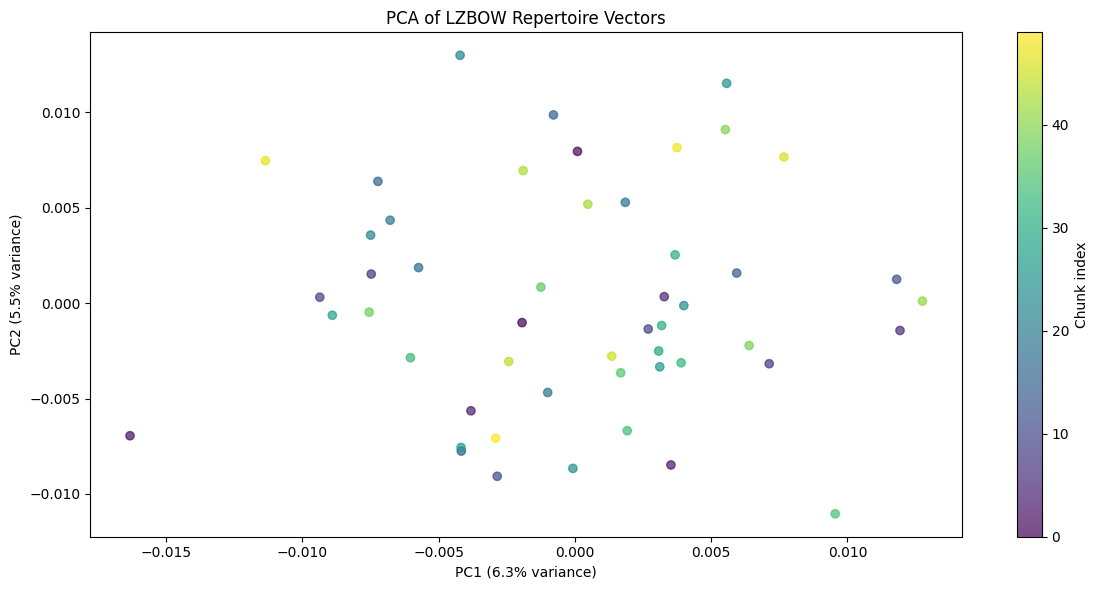

In [13]:
from sklearn.decomposition import PCA

# Create small "repertoires" by splitting data into chunks of 100 sequences
chunk_size = 100
n_chunks = len(sequences) // chunk_size

# Fit BOW on all sequences
bow_pca = LZBOW(encoding_function=AAPLZGraph.encode_sequence)
bow_pca.fit(sequences)

# Get a normalized vector for each chunk (simulated repertoire)
chunk_vectors = []
for i in range(n_chunks):
    chunk = sequences[i * chunk_size : (i + 1) * chunk_size]
    vec = bow_pca.transform(chunk, normalize=True)
    chunk_vectors.append(vec)

X = np.array(chunk_vectors)
print(f"Feature matrix: {X.shape} ({n_chunks} mini-repertoires x {bow_pca.dictionary_size} features)")

# PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Plot — color by chunk index to see ordering effects
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=range(n_chunks), cmap='viridis', alpha=0.7)
plt.colorbar(label='Chunk index')
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)')
plt.title('PCA of LZBOW Repertoire Vectors')
plt.tight_layout()
plt.show()

## Summary

| Method | Description |
|--------|-------------|
| `LZBOW(encoding_function)` | Create encoder (pass `AAPLZGraph.encode_sequence`, `NDPLZGraph.encode_sequence`, or default for naive) |
| `.fit(sequences)` | Build vocabulary from sequences |
| `.transform(sequences)` | Convert to count vectors |
| `.fit_transform(sequences)` | Fit + transform in one step |
| `.tfidf_transform(sequences)` | TF-IDF weighted vectors |
| `bow1 + bow2` | Merge two encoders' vocabularies |

Key parameters:
- `normalize=True`: Return frequency vectors (rows sum to 1)
- `per_sequence=True`: Return a matrix (one row per sequence) instead of a single aggregate vector